In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Stromal"
)
DIR2SAVE.mkdir(parents=True, exist_ok=True)

In [3]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [4]:
# load general annotations to isolate Stromal cells only
general_annot = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/annotation_global/Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_clustering.h5ad"
)

In [5]:
# these are the cells we need to extract from the raw data to get raw counts
idx2extract = general_annot[general_annot.obs.Annotation_scVI == "Stromal"].obs.index

In [6]:
# load raw counts from merged object
adata_raw = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/data_integration/Multiome_Che_Wu_CRC_LM_raw.h5ad"
)

In [7]:
# select from the raw data only the barcodes of interest, select raw counts from cell population of interest
adata = adata_raw[adata_raw.obs.index.isin(idx2extract)].copy()
adata.shape

(1009, 37102)

In [8]:
# add global annotations to raw data
adata.obs = adata.obs.merge(
    right=general_annot.obs[["Annotation_scVI"]],
    how="left",
    right_index=True,
    left_index=True,
)

In [9]:
# check that it is raw data
np.max(adata.X)

2517.0

In [10]:
adata.obs.Patient.value_counts()

COL15         142
CRC10         132
CRC08         108
COL18          92
CRC12          75
CRC02          69
CRC06          57
COL17          56
CRC09          50
CRC15          40
CRC03          37
CRC11          35
CRC14          23
COL12          20
CRC04          17
COL16          16
CRC13          14
CRC05          11
COL07           8
Wu2021_P5       2
CRC01           2
Wu2021_P12      1
Wu2021_P17      1
CRC07           1
Name: Patient, dtype: int64

### Only keep patients that have at least 3 cells for annotation

In [11]:
patient_nbcell_df = adata.obs.Patient.value_counts().reset_index()

In [13]:
patients2keep = patient_nbcell_df[patient_nbcell_df["Patient"] >= 3]["index"]

In [14]:
patients2keep

0     COL15
1     CRC10
2     CRC08
3     COL18
4     CRC12
5     CRC02
6     CRC06
7     COL17
8     CRC09
9     CRC15
10    CRC03
11    CRC11
12    CRC14
13    COL12
14    CRC04
15    COL16
16    CRC13
17    CRC05
18    COL07
Name: index, dtype: category
Categories (24, object): ['COL07', 'COL12', 'COL15', 'COL16', ..., 'CRC15', 'Wu2021_P12', 'Wu2021_P17', 'Wu2021_P5']

In [15]:
adata = adata[adata.obs.Patient.isin(patients2keep)].copy()

In [16]:
adata.obs.Patient.value_counts()

COL15    142
CRC10    132
CRC08    108
COL18     92
CRC12     75
CRC02     69
CRC06     57
COL17     56
CRC09     50
CRC15     40
CRC03     37
CRC11     35
CRC14     23
COL12     20
CRC04     17
COL16     16
CRC13     14
CRC05     11
COL07      8
Name: Patient, dtype: int64

In [17]:
adata.obs.cell_source.value_counts()

BCI-Nuclei    668
Che-Cells     334
Name: cell_source, dtype: int64

### look at covariates

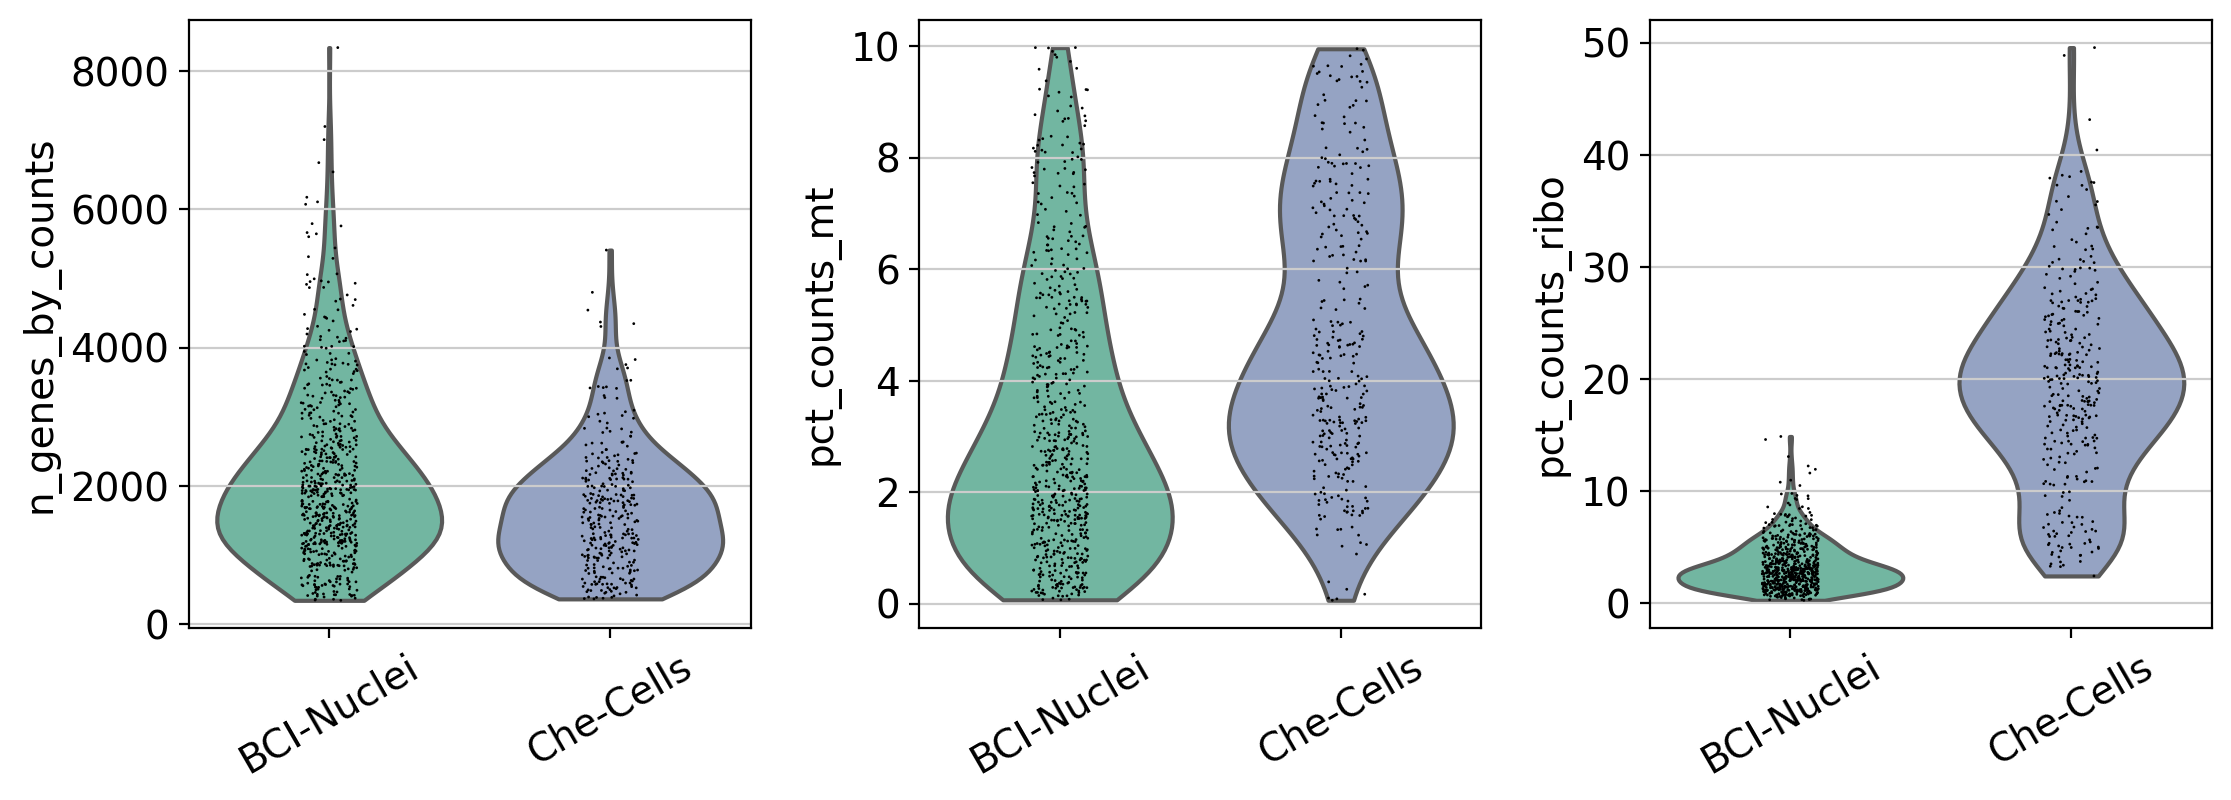

In [18]:
# violin plot of some distributions
sc.pl.violin(
    adata,
    keys=["n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"],
    groupby="cell_source",
    jitter=0.1,
    multi_panel=True,
    rotation=30,
    show=True,
    # save="QC_covariates.pdf",
)

### Normalise + log transform + HVG

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.


In [19]:
# keep raw
adata.layers["raw"] = adata.X.copy()  # preserve counts

# normalize + log1p
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
adata.layers["normalised"] = adata.X.copy()
sc.pp.log1p(adata)

adata.layers["log1p"] = adata.X.copy()

The count data has been normalized and log-transforme d with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

In [20]:
adata.raw = adata  # keep normalised log1p

### Compute cell cycle scores 

In [21]:
def cell_cycle_scoring(adata, cc_genes_file, subtract=False, use_raw=True):
    """
    Computes cell cycle G2M and S phase scores using provided list
    :param adata: need log1p normalised data
    :param cc_genes_file: list of cell cycling genes (often list provided Macosko et al. 2015)
    :param subtract: compute the difference between the S and G2M scores
    :param use_raw: adata.raw where log1p norm is stored, by default True
    :return:
    """
    cc_genes = pd.read_csv(cc_genes_file)

    cc_genes = list(cc_genes["Cell_cycle_genes"])

    # select only cell cycle genes involved in phase S
    cc_genes_s = cc_genes[:43]
    # select only cell cycle genes involved in phase G2/M
    cc_genes_g2m = cc_genes[43:]

    # select cc_genes that are in our gene repertoire
    # isin is an element-wise function version of the python keyword in. isin(a, b) is roughly equivalent to
    # np.array([item in b for item in a]) if a and b are 1-D sequences.
    # cc_genes_s_var = adata.raw.to_adata().var_names[np.isin(adata.raw.to_adata().var_names, cc_genes_s)]
    # cc_genes_g2m_var = adata.raw.to_adata().var_names[np.in1d(adata.raw.to_adata(), cc_genes_g2m)]

    cc_genes_s_var = [
        ele for ele in cc_genes_s if ele in adata.raw.to_adata().var_names
    ]
    cc_genes_g2m_var = [
        ele for ele in cc_genes_g2m if ele in adata.raw.to_adata().var_names
    ]

    # to ensure reproducibility from issue https://github.com/theislab/scanpy/issues/313
    # adata.X = adata.X.astype('<f8')  # Make float64 to ensure stability

    sc.tl.score_genes_cell_cycle(
        adata,
        s_genes=cc_genes_s_var,
        g2m_genes=cc_genes_g2m_var,
        random_state=7,
        use_raw=use_raw,
    )

    if subtract:  # https://satijalab.org/seurat/archive/v3.0/cell_cycle_vignette.html
        # regressing out the difference between the G2M and S phase scores.
        # This means that signals separating non-cycling cells and cycling cells will be maintained,
        # but differences in cell cycle phase amongst proliferating cells (which are often uninteresting),
        # subtracting scores individually removes all signal associated with cell cycle but not always good.
        # Sometimes useful to try differences
        # particularly in differentiating processes (like murine hematopoiesis), where stem cells are quiescent
        # and differentiated cells are proliferating. Regressing out all cell cycle effects can blur the distinction
        # between stem and progenitor cells as well
        adata.obs["cell_cycle_diff"] = adata.obs["S_score"] - adata.obs["G2M_score"]
        # https://github.com/theislab/scanpy/issues/526

    # adata.X = adata.X.astype('<f4')  # Return to float32 for consistency

    return adata

In [22]:
cell_cycle_scoring(
    adata,
    cc_genes_file="/data/BCI-CRC/nasrine/data/Tirosh2016_coreCellCycle.csv",
    subtract=True,
    use_raw=True,
)  # use log1p norm data

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


AnnData object with n_obs × n_vars = 1002 × 37102
    obs: 'Patient', 'Sample', 'Cell_type', 'Cell_subtype', 'Tissue', 'Therapy', 'doublet_score', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'cell_source', 'Annotation_scVI', 'S_score', 'G2M_score', 'phase', 'cell_cycle_diff'
    var: 'n_cells'
    uns: 'Therapy_colors', 'Tissue_colors', 'cell_source_colors', 'log1p'
    layers: 'raw', 'normalised', 'log1p'

### HVG 
We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

**Expects logarithmized data, except when `flavor='seurat_v3'` in which
count data is expected.**

In [23]:
sc.pp.highly_variable_genes(
    adata,
    subset=True,  # subset for integration (but full lognorm data in .raw)
    layer="raw",
    flavor="seurat_v3",
    n_top_genes=2000,
    span=0.3,
    min_disp=0.5,
    min_mean=0.0125,
    max_mean=3,
    # batch_key="cell_source",
)

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [24]:
adata.X.shape

(1002, 2000)

In [25]:
adata.raw.to_adata().X.shape

(1002, 37102)

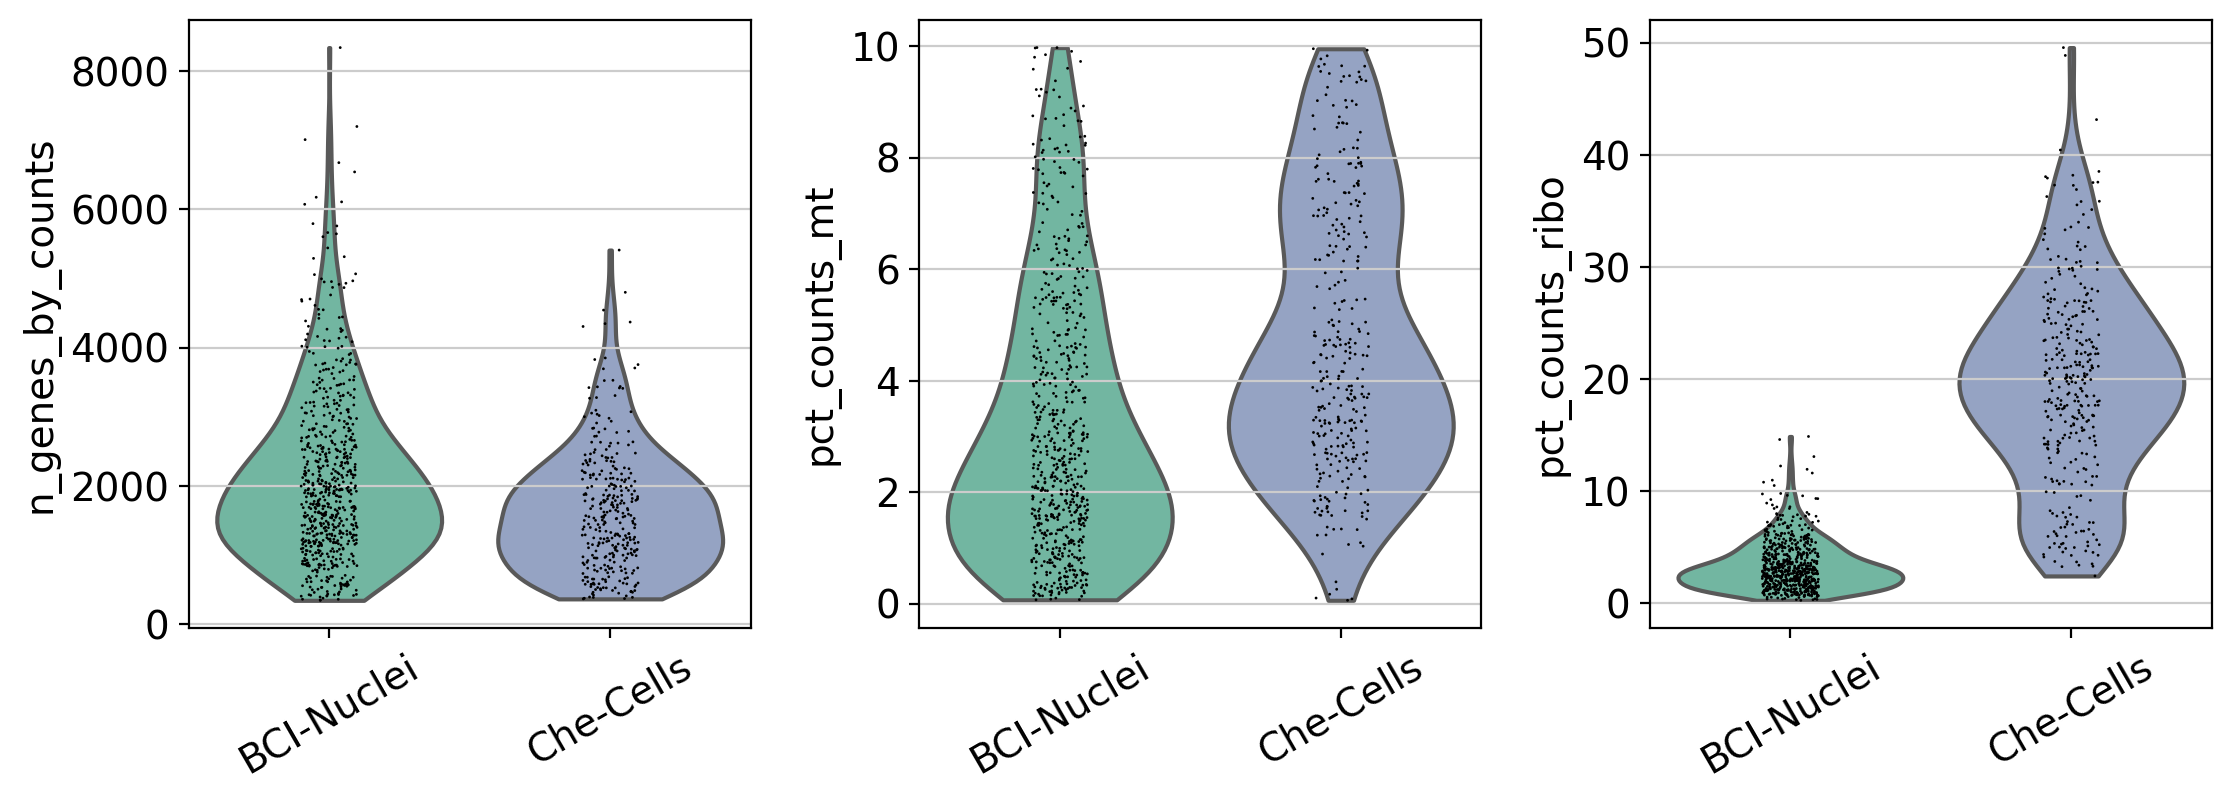

In [26]:
# violin plot of some distributions
sc.pl.violin(
    adata,
    keys=["n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"],
    groupby="cell_source",
    jitter=0.1,
    multi_panel=True,
    rotation=30,
    show=True,
    save="QC_covariates.pdf",
)

### scVI
Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized).

Now it’s time to run setup_anndata(), which alerts scvi-tools to the locations of various matrices inside the anndata. It’s important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a “cell_source” categorical covariate, and within each “cell_source”, multiple “patients”. There are also two continuous covariates we’d like to correct for: “percent_mito” and “percent_ribo”. These covariates can be registered using the categorical_covariate_keys argument. If you only have one categorical covariate, you can also use the batch_key argument instead.



In [27]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="raw",
    categorical_covariate_keys=["cell_source", "Patient"],
    continuous_covariate_keys=[
        "pct_counts_mt",
        "pct_counts_ribo",
    ],  # add cell cycle here if you want to correct for this
)

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[raw] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


#### Creating and training a model

In [28]:
model = scvi.model.SCVI(adata, n_latent=15)  # n_latent=10
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 15, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [29]:
model.train()

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - 

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 3/400:   0%|          | 2/400 [00:01<05:12,  1.27it/s, loss=1.15e+03, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/400:   1%|          | 4/400 [00:02<02:15,  2.92it/s, loss=937, v_num=1]     

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/400:   2%|▏         | 6/400 [00:02<01:23,  4.73it/s, loss=845, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 9/400:   2%|▏         | 8/400 [00:02<01:08,  5.71it/s, loss=800, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 11/400:   2%|▎         | 10/400 [00:02<00:58,  6.71it/s, loss=778, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 13/400:   3%|▎         | 12/400 [00:03<00:51,  7.55it/s, loss=760, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 15/400:   4%|▎         | 14/400 [00:03<00:47,  8.12it/s, loss=755, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 17/400:   4%|▍         | 16/400 [00:03<00:45,  8.48it/s, loss=732, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 19/400:   4%|▍         | 18/400 [00:03<00:44,  8.62it/s, loss=723, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 21/400:   5%|▌         | 20/400 [00:04<00:44,  8.63it/s, loss=744, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 23/400:   6%|▌         | 22/400 [00:04<00:44,  8.54it/s, loss=726, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 25/400:   6%|▌         | 24/400 [00:04<00:43,  8.63it/s, loss=721, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 27/400:   6%|▋         | 26/400 [00:04<00:42,  8.72it/s, loss=705, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 29/400:   7%|▋         | 28/400 [00:04<00:42,  8.76it/s, loss=718, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 31/400:   8%|▊         | 30/400 [00:05<00:42,  8.62it/s, loss=725, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 33/400:   8%|▊         | 32/400 [00:05<00:42,  8.64it/s, loss=716, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 35/400:   8%|▊         | 34/400 [00:05<00:42,  8.65it/s, loss=706, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 37/400:   9%|▉         | 36/400 [00:05<00:41,  8.73it/s, loss=693, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 39/400:  10%|▉         | 38/400 [00:06<00:41,  8.76it/s, loss=700, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 41/400:  10%|█         | 40/400 [00:06<00:41,  8.73it/s, loss=674, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 43/400:  10%|█         | 42/400 [00:06<00:40,  8.74it/s, loss=661, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 45/400:  11%|█         | 44/400 [00:06<00:40,  8.77it/s, loss=678, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 47/400:  12%|█▏        | 46/400 [00:07<00:41,  8.61it/s, loss=691, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 49/400:  12%|█▏        | 48/400 [00:07<00:41,  8.49it/s, loss=700, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 51/400:  12%|█▎        | 50/400 [00:07<00:40,  8.59it/s, loss=677, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 53/400:  13%|█▎        | 52/400 [00:07<00:39,  8.71it/s, loss=678, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 55/400:  14%|█▎        | 54/400 [00:07<00:39,  8.72it/s, loss=670, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 57/400:  14%|█▍        | 56/400 [00:08<00:39,  8.74it/s, loss=706, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 59/400:  14%|█▍        | 58/400 [00:08<00:39,  8.76it/s, loss=685, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 61/400:  15%|█▌        | 60/400 [00:08<00:39,  8.70it/s, loss=655, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 63/400:  16%|█▌        | 62/400 [00:08<00:38,  8.77it/s, loss=682, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 65/400:  16%|█▌        | 64/400 [00:09<00:38,  8.75it/s, loss=663, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 67/400:  16%|█▋        | 66/400 [00:09<00:37,  8.82it/s, loss=668, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 69/400:  17%|█▋        | 68/400 [00:09<00:37,  8.79it/s, loss=659, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 71/400:  18%|█▊        | 70/400 [00:09<00:37,  8.79it/s, loss=657, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 73/400:  18%|█▊        | 72/400 [00:10<00:37,  8.72it/s, loss=680, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 75/400:  18%|█▊        | 74/400 [00:10<00:37,  8.71it/s, loss=668, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 77/400:  19%|█▉        | 76/400 [00:10<00:36,  8.78it/s, loss=659, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 79/400:  20%|█▉        | 78/400 [00:10<00:36,  8.81it/s, loss=652, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 81/400:  20%|██        | 80/400 [00:10<00:36,  8.80it/s, loss=663, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 83/400:  20%|██        | 82/400 [00:11<00:36,  8.82it/s, loss=655, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 85/400:  21%|██        | 84/400 [00:11<00:36,  8.70it/s, loss=684, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 87/400:  22%|██▏       | 86/400 [00:11<00:35,  8.73it/s, loss=659, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 89/400:  22%|██▏       | 88/400 [00:11<00:39,  7.88it/s, loss=673, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 91/400:  22%|██▎       | 90/400 [00:12<00:37,  8.35it/s, loss=659, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 93/400:  23%|██▎       | 92/400 [00:12<00:35,  8.64it/s, loss=658, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 95/400:  24%|██▎       | 94/400 [00:12<00:34,  8.80it/s, loss=655, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 97/400:  24%|██▍       | 96/400 [00:12<00:34,  8.86it/s, loss=641, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 99/400:  24%|██▍       | 98/400 [00:12<00:33,  8.88it/s, loss=647, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 101/400:  25%|██▌       | 100/400 [00:13<00:33,  8.89it/s, loss=674, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 103/400:  26%|██▌       | 102/400 [00:13<00:33,  8.90it/s, loss=677, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 105/400:  26%|██▌       | 104/400 [00:13<00:33,  8.91it/s, loss=635, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 107/400:  26%|██▋       | 106/400 [00:13<00:33,  8.86it/s, loss=664, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 109/400:  27%|██▋       | 108/400 [00:14<00:33,  8.76it/s, loss=660, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 111/400:  28%|██▊       | 110/400 [00:14<00:33,  8.69it/s, loss=670, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 113/400:  28%|██▊       | 112/400 [00:14<00:32,  8.77it/s, loss=678, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 115/400:  28%|██▊       | 114/400 [00:14<00:33,  8.49it/s, loss=643, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 117/400:  29%|██▉       | 116/400 [00:15<00:32,  8.61it/s, loss=631, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 119/400:  30%|██▉       | 118/400 [00:15<00:32,  8.69it/s, loss=636, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 121/400:  30%|███       | 120/400 [00:15<00:32,  8.72it/s, loss=626, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 123/400:  30%|███       | 122/400 [00:15<00:31,  8.78it/s, loss=638, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 125/400:  31%|███       | 124/400 [00:15<00:31,  8.82it/s, loss=649, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 127/400:  32%|███▏      | 126/400 [00:16<00:30,  8.90it/s, loss=642, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 129/400:  32%|███▏      | 128/400 [00:16<00:30,  8.92it/s, loss=632, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 131/400:  32%|███▎      | 130/400 [00:16<00:30,  8.90it/s, loss=625, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 133/400:  33%|███▎      | 132/400 [00:16<00:30,  8.92it/s, loss=646, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 135/400:  34%|███▎      | 134/400 [00:17<00:29,  8.94it/s, loss=632, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 137/400:  34%|███▍      | 136/400 [00:17<00:29,  8.87it/s, loss=634, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 139/400:  34%|███▍      | 138/400 [00:17<00:29,  8.81it/s, loss=672, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 141/400:  35%|███▌      | 140/400 [00:17<00:29,  8.80it/s, loss=654, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 143/400:  36%|███▌      | 142/400 [00:17<00:29,  8.80it/s, loss=637, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 145/400:  36%|███▌      | 144/400 [00:18<00:28,  8.87it/s, loss=636, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 147/400:  36%|███▋      | 146/400 [00:18<00:28,  8.77it/s, loss=645, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 149/400:  37%|███▋      | 148/400 [00:18<00:28,  8.79it/s, loss=655, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 151/400:  38%|███▊      | 150/400 [00:18<00:28,  8.85it/s, loss=632, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 153/400:  38%|███▊      | 152/400 [00:19<00:27,  8.86it/s, loss=621, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 155/400:  38%|███▊      | 154/400 [00:19<00:27,  8.84it/s, loss=629, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 157/400:  39%|███▉      | 156/400 [00:19<00:27,  8.90it/s, loss=622, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 159/400:  40%|███▉      | 158/400 [00:19<00:27,  8.89it/s, loss=625, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 161/400:  40%|████      | 160/400 [00:20<00:26,  8.89it/s, loss=626, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 163/400:  40%|████      | 162/400 [00:20<00:26,  8.90it/s, loss=639, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 165/400:  41%|████      | 164/400 [00:20<00:26,  8.87it/s, loss=674, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 167/400:  42%|████▏     | 166/400 [00:20<00:26,  8.92it/s, loss=625, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 169/400:  42%|████▏     | 168/400 [00:20<00:25,  8.92it/s, loss=620, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 171/400:  42%|████▎     | 170/400 [00:21<00:25,  8.94it/s, loss=614, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 173/400:  43%|████▎     | 172/400 [00:21<00:26,  8.61it/s, loss=612, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 175/400:  44%|████▎     | 174/400 [00:21<00:25,  8.76it/s, loss=612, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 177/400:  44%|████▍     | 176/400 [00:21<00:25,  8.87it/s, loss=626, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 179/400:  44%|████▍     | 178/400 [00:22<00:24,  8.92it/s, loss=620, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 181/400:  45%|████▌     | 180/400 [00:22<00:24,  8.84it/s, loss=617, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 183/400:  46%|████▌     | 182/400 [00:22<00:24,  8.77it/s, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 185/400:  46%|████▌     | 184/400 [00:22<00:24,  8.77it/s, loss=622, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 187/400:  46%|████▋     | 186/400 [00:22<00:24,  8.80it/s, loss=628, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 189/400:  47%|████▋     | 188/400 [00:23<00:24,  8.83it/s, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 191/400:  48%|████▊     | 190/400 [00:23<00:23,  8.82it/s, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 193/400:  48%|████▊     | 192/400 [00:23<00:23,  8.77it/s, loss=620, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 195/400:  48%|████▊     | 194/400 [00:23<00:23,  8.80it/s, loss=613, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 197/400:  49%|████▉     | 196/400 [00:24<00:23,  8.85it/s, loss=620, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 199/400:  50%|████▉     | 198/400 [00:24<00:22,  8.83it/s, loss=647, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 201/400:  50%|█████     | 200/400 [00:24<00:22,  8.83it/s, loss=624, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 203/400:  50%|█████     | 202/400 [00:24<00:22,  8.89it/s, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 205/400:  51%|█████     | 204/400 [00:25<00:21,  8.92it/s, loss=618, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 207/400:  52%|█████▏    | 206/400 [00:25<00:21,  8.94it/s, loss=609, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 209/400:  52%|█████▏    | 208/400 [00:25<00:21,  8.90it/s, loss=621, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 211/400:  52%|█████▎    | 210/400 [00:25<00:21,  8.92it/s, loss=620, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 213/400:  53%|█████▎    | 212/400 [00:25<00:21,  8.90it/s, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 215/400:  54%|█████▎    | 214/400 [00:26<00:20,  8.90it/s, loss=611, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 217/400:  54%|█████▍    | 216/400 [00:26<00:20,  8.79it/s, loss=619, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 219/400:  55%|█████▍    | 218/400 [00:26<00:20,  8.84it/s, loss=614, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 221/400:  55%|█████▌    | 220/400 [00:26<00:20,  8.88it/s, loss=612, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 223/400:  56%|█████▌    | 222/400 [00:27<00:19,  8.92it/s, loss=629, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 225/400:  56%|█████▌    | 224/400 [00:27<00:19,  8.90it/s, loss=632, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 227/400:  56%|█████▋    | 226/400 [00:27<00:19,  8.90it/s, loss=633, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 229/400:  57%|█████▋    | 228/400 [00:27<00:19,  8.87it/s, loss=613, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 231/400:  57%|█████▊    | 230/400 [00:27<00:19,  8.90it/s, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 233/400:  58%|█████▊    | 232/400 [00:28<00:18,  8.90it/s, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 235/400:  58%|█████▊    | 234/400 [00:28<00:18,  8.92it/s, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 237/400:  59%|█████▉    | 236/400 [00:28<00:18,  8.91it/s, loss=625, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 239/400:  60%|█████▉    | 238/400 [00:28<00:18,  8.88it/s, loss=614, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 241/400:  60%|██████    | 240/400 [00:29<00:18,  8.81it/s, loss=610, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 243/400:  60%|██████    | 242/400 [00:29<00:17,  8.87it/s, loss=622, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 245/400:  61%|██████    | 244/400 [00:29<00:17,  8.74it/s, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 247/400:  62%|██████▏   | 246/400 [00:29<00:17,  8.82it/s, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 249/400:  62%|██████▏   | 248/400 [00:29<00:17,  8.88it/s, loss=618, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 251/400:  62%|██████▎   | 250/400 [00:30<00:16,  8.92it/s, loss=608, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 253/400:  63%|██████▎   | 252/400 [00:30<00:16,  8.94it/s, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 255/400:  64%|██████▎   | 254/400 [00:30<00:16,  8.93it/s, loss=582, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 257/400:  64%|██████▍   | 256/400 [00:30<00:16,  8.91it/s, loss=623, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 259/400:  64%|██████▍   | 258/400 [00:31<00:16,  8.87it/s, loss=620, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 261/400:  65%|██████▌   | 260/400 [00:31<00:15,  8.90it/s, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 263/400:  66%|██████▌   | 262/400 [00:31<00:15,  8.89it/s, loss=622, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 265/400:  66%|██████▌   | 264/400 [00:31<00:15,  8.92it/s, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 267/400:  66%|██████▋   | 266/400 [00:31<00:14,  8.95it/s, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 269/400:  67%|██████▋   | 268/400 [00:32<00:14,  8.93it/s, loss=620, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 271/400:  68%|██████▊   | 270/400 [00:32<00:14,  8.92it/s, loss=611, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 273/400:  68%|██████▊   | 272/400 [00:32<00:14,  8.85it/s, loss=607, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 275/400:  68%|██████▊   | 274/400 [00:32<00:14,  8.87it/s, loss=610, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 277/400:  69%|██████▉   | 276/400 [00:33<00:13,  8.93it/s, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 279/400:  70%|██████▉   | 278/400 [00:33<00:13,  8.88it/s, loss=617, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 281/400:  70%|███████   | 280/400 [00:33<00:13,  8.92it/s, loss=612, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 283/400:  70%|███████   | 282/400 [00:33<00:13,  8.93it/s, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 285/400:  71%|███████   | 284/400 [00:34<00:12,  8.95it/s, loss=607, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 287/400:  72%|███████▏  | 286/400 [00:34<00:12,  8.95it/s, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 289/400:  72%|███████▏  | 288/400 [00:34<00:12,  8.92it/s, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 291/400:  72%|███████▎  | 290/400 [00:34<00:12,  8.89it/s, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 293/400:  73%|███████▎  | 292/400 [00:34<00:12,  8.89it/s, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 295/400:  74%|███████▎  | 294/400 [00:35<00:11,  8.84it/s, loss=609, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 297/400:  74%|███████▍  | 296/400 [00:35<00:11,  8.92it/s, loss=620, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 299/400:  74%|███████▍  | 298/400 [00:35<00:11,  8.88it/s, loss=611, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 301/400:  75%|███████▌  | 300/400 [00:35<00:11,  8.85it/s, loss=594, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 303/400:  76%|███████▌  | 302/400 [00:36<00:11,  8.87it/s, loss=589, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 305/400:  76%|███████▌  | 304/400 [00:36<00:10,  8.91it/s, loss=607, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 307/400:  76%|███████▋  | 306/400 [00:36<00:10,  8.88it/s, loss=610, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 309/400:  77%|███████▋  | 308/400 [00:36<00:10,  8.87it/s, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 311/400:  78%|███████▊  | 310/400 [00:36<00:10,  8.90it/s, loss=614, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 313/400:  78%|███████▊  | 312/400 [00:37<00:09,  8.91it/s, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 315/400:  78%|███████▊  | 314/400 [00:37<00:09,  8.92it/s, loss=592, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 317/400:  79%|███████▉  | 316/400 [00:37<00:09,  8.80it/s, loss=583, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 319/400:  80%|███████▉  | 318/400 [00:37<00:09,  8.87it/s, loss=597, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 321/400:  80%|████████  | 320/400 [00:38<00:08,  8.90it/s, loss=586, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 323/400:  80%|████████  | 322/400 [00:38<00:08,  8.91it/s, loss=603, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 325/400:  81%|████████  | 324/400 [00:38<00:09,  7.99it/s, loss=615, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 327/400:  82%|████████▏ | 326/400 [00:38<00:08,  8.35it/s, loss=580, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 329/400:  82%|████████▏ | 328/400 [00:39<00:08,  8.55it/s, loss=579, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 331/400:  82%|████████▎ | 330/400 [00:39<00:08,  8.67it/s, loss=589, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 333/400:  83%|████████▎ | 332/400 [00:39<00:07,  8.75it/s, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 335/400:  84%|████████▎ | 334/400 [00:39<00:07,  8.76it/s, loss=584, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 337/400:  84%|████████▍ | 336/400 [00:39<00:07,  8.77it/s, loss=580, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 339/400:  84%|████████▍ | 338/400 [00:40<00:07,  8.77it/s, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 341/400:  85%|████████▌ | 340/400 [00:40<00:06,  8.78it/s, loss=598, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 343/400:  86%|████████▌ | 342/400 [00:40<00:06,  8.77it/s, loss=599, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 345/400:  86%|████████▌ | 344/400 [00:40<00:06,  8.77it/s, loss=601, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 347/400:  86%|████████▋ | 346/400 [00:41<00:06,  8.80it/s, loss=565, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 349/400:  87%|████████▋ | 348/400 [00:41<00:05,  8.79it/s, loss=583, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 351/400:  88%|████████▊ | 350/400 [00:41<00:05,  8.79it/s, loss=588, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 353/400:  88%|████████▊ | 352/400 [00:41<00:05,  8.78it/s, loss=578, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 355/400:  88%|████████▊ | 354/400 [00:41<00:05,  8.80it/s, loss=573, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 357/400:  89%|████████▉ | 356/400 [00:42<00:04,  8.81it/s, loss=588, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 359/400:  90%|████████▉ | 358/400 [00:42<00:04,  8.79it/s, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 361/400:  90%|█████████ | 360/400 [00:42<00:04,  8.78it/s, loss=610, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 363/400:  90%|█████████ | 362/400 [00:42<00:04,  8.76it/s, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 365/400:  91%|█████████ | 364/400 [00:43<00:04,  8.74it/s, loss=591, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 367/400:  92%|█████████▏| 366/400 [00:43<00:03,  8.70it/s, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 369/400:  92%|█████████▏| 368/400 [00:43<00:03,  8.70it/s, loss=605, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 371/400:  92%|█████████▎| 370/400 [00:43<00:03,  8.73it/s, loss=638, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 373/400:  93%|█████████▎| 372/400 [00:44<00:03,  8.76it/s, loss=606, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 375/400:  94%|█████████▎| 374/400 [00:44<00:02,  8.78it/s, loss=596, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 377/400:  94%|█████████▍| 376/400 [00:44<00:02,  8.79it/s, loss=615, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 379/400:  94%|█████████▍| 378/400 [00:44<00:02,  8.77it/s, loss=604, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 381/400:  95%|█████████▌| 380/400 [00:44<00:02,  8.80it/s, loss=587, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 383/400:  96%|█████████▌| 382/400 [00:45<00:02,  8.78it/s, loss=584, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 385/400:  96%|█████████▌| 384/400 [00:45<00:01,  8.80it/s, loss=593, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 387/400:  96%|█████████▋| 386/400 [00:45<00:01,  8.77it/s, loss=587, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 389/400:  97%|█████████▋| 388/400 [00:45<00:01,  8.78it/s, loss=581, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 391/400:  98%|█████████▊| 390/400 [00:46<00:01,  8.79it/s, loss=586, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 393/400:  98%|█████████▊| 392/400 [00:46<00:00,  8.80it/s, loss=587, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 395/400:  98%|█████████▊| 394/400 [00:46<00:00,  8.80it/s, loss=590, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 397/400:  99%|█████████▉| 396/400 [00:46<00:00,  8.79it/s, loss=600, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 399/400: 100%|█████████▉| 398/400 [00:46<00:00,  8.79it/s, loss=602, v_num=1]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 400/400: 100%|██████████| 400/400 [00:47<00:00,  8.47it/s, loss=601, v_num=1]


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


In [30]:
# save model
model.save(os.path.join(DIR2SAVE, "scvi_model_hvg_mt_ribo"))

In [31]:
# read the model
model = scvi.model.SCVI.load(
    os.path.join(DIR2SAVE, "scvi_model_hvg_mt_ribo"), adata=adata
)  # , use_gpu=True)

INFO     File /data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/Stromal
         /scvi_model_hvg_mt_ribo/model.pt already downloaded                                 


/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.layers[raw] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [32]:
latent = model.get_latent_representation()  # get model output

In [33]:
latent.shape

(1002, 15)

In [34]:
# It’s often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with
# Scanpy.
adata.obsm["X_scVI"] = latent

In [35]:
# Let’s store the normalized values back in the anndata.
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    adata=adata, library_size=1e4
)

### Visualization without batch correction

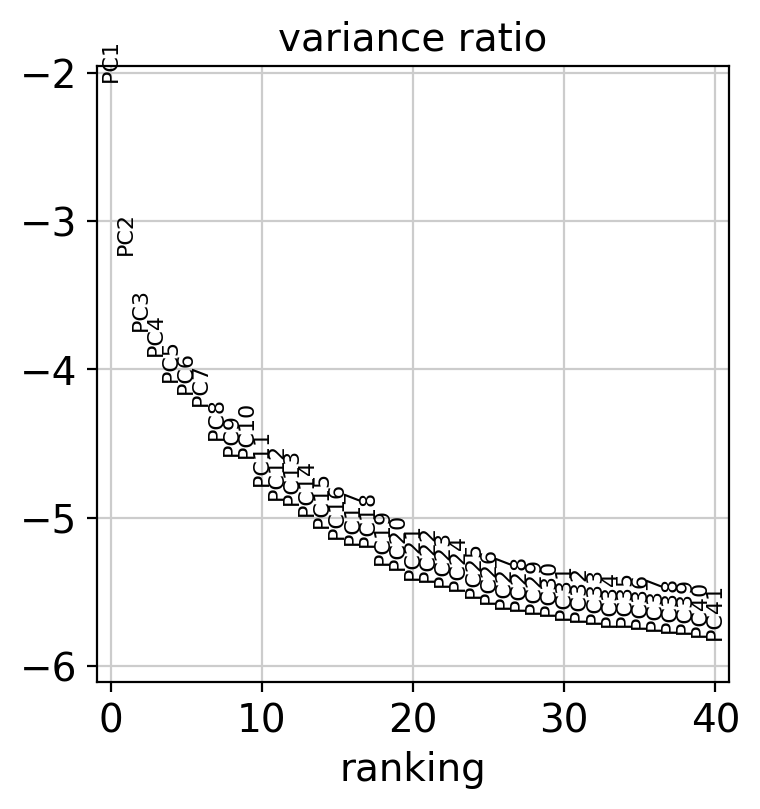

In [36]:
# perform PCA on adata_liver (which contains only HVG (after normalized, log1p) and scaled
sc.tl.pca(adata, svd_solver="arpack", use_highly_variable=True, random_state=7)

# Elbow plot
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=40, show=True)

# compute neighbourhood graph
sc.pp.neighbors(
    adata,
    n_neighbors=5,
    n_pcs=15,
    knn=True,
    method="umap",
    metric="euclidean",
    random_state=7,
)

# compute UMAP embedding
sc.tl.umap(adata, min_dist=0.3, n_components=2, random_state=7)

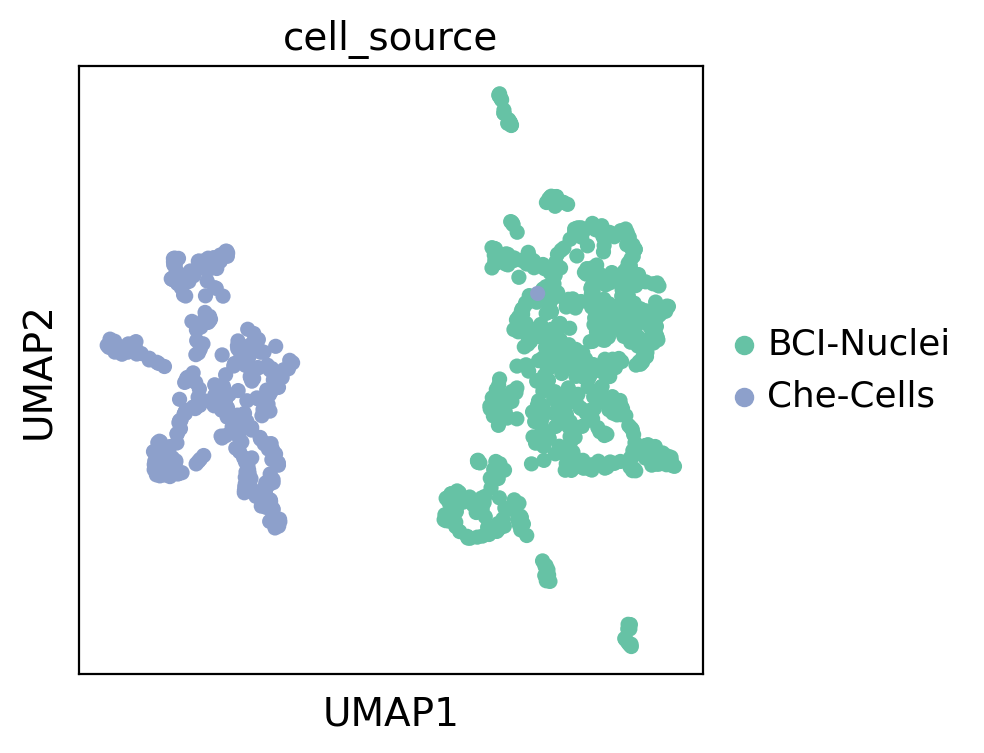

In [37]:
sc.pl.umap(adata, color="cell_source", save="before_integration_scvi.pdf", show=True)

### With batch correction - scVI

In [38]:
print("Number of PCs:", latent.shape[1])
# use scVI latent space for UMAP generation
# set nb pcs to latent representation shape of scvi
# compute neighbourhood graph
sc.pp.neighbors(
    adata,
    n_neighbors=5,
    n_pcs=latent.shape[1],
    knn=True,
    method="umap",
    metric="euclidean",
    use_rep="X_scVI",
    random_state=7,
)

# compute UMAP embedding
sc.tl.umap(adata, min_dist=0.3, n_components=2, random_state=7)

Number of PCs: 15


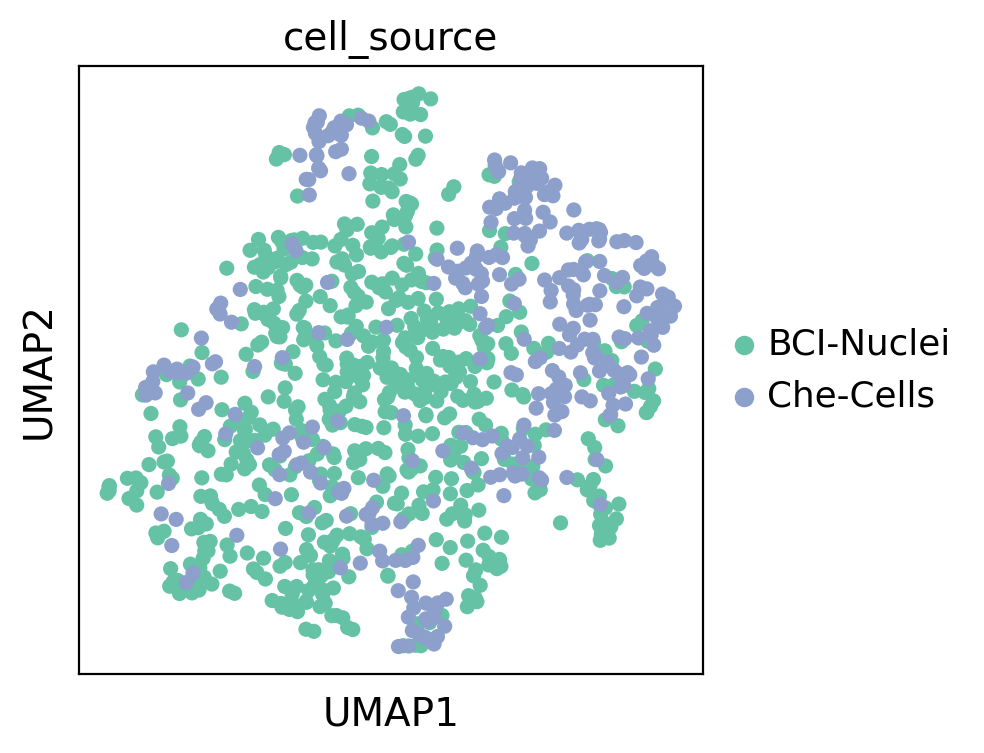

In [39]:
sc.pl.umap(adata, color="cell_source", save="after_integration_scvi.pdf", show=True)

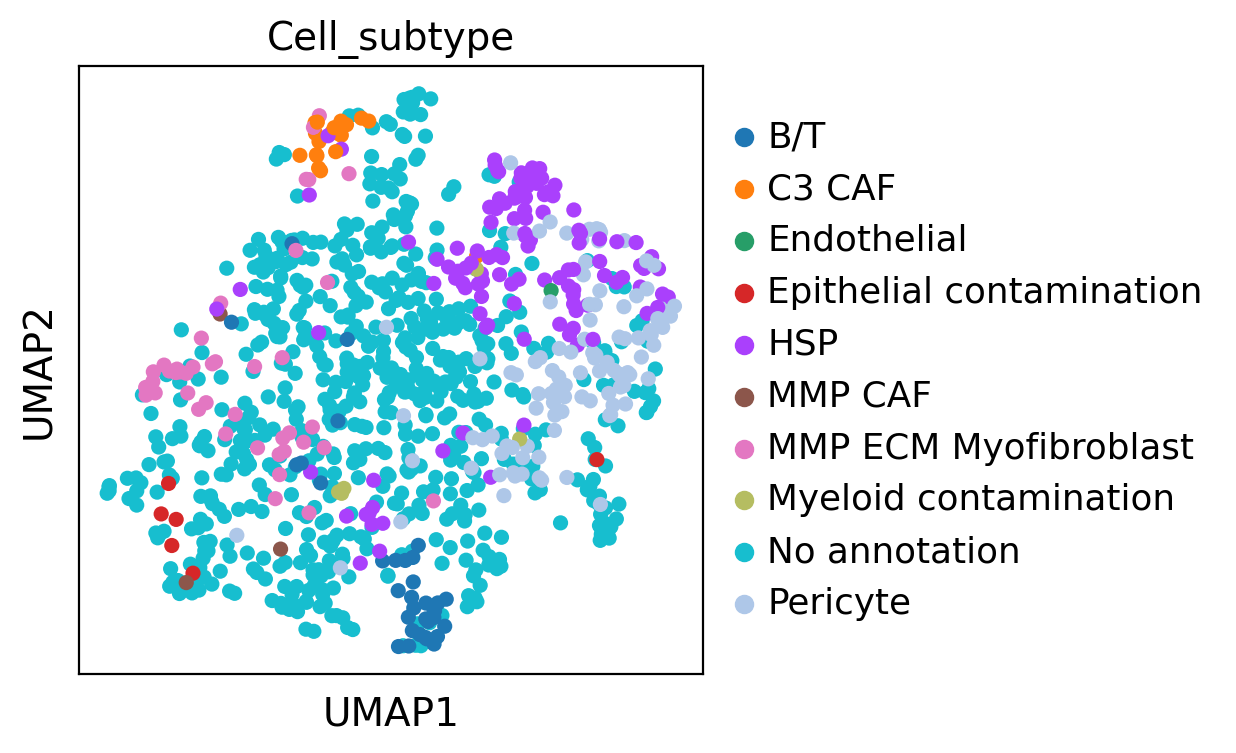

In [40]:
sc.pl.umap(adata, color="Cell_subtype")

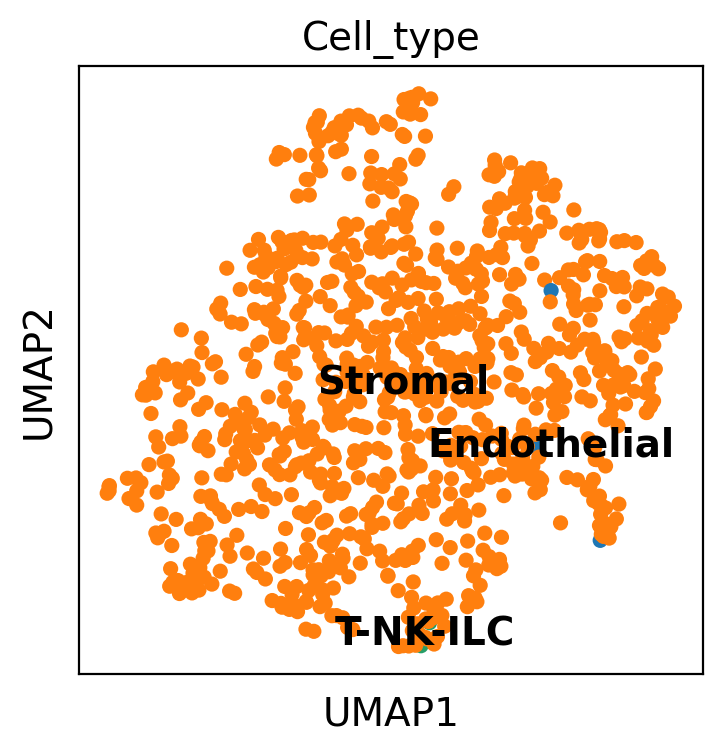

In [41]:
sc.pl.umap(adata, color="Cell_type", legend_loc="on data")

In [42]:
# save to file
adata.write(
    DIR2SAVE.joinpath("Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_Stromal.h5ad")
)

In [43]:
adata.obs.Cell_type.value_counts()

Stromal        997
Endothelial      3
T-NK-ILC         2
Name: Cell_type, dtype: int64